In [38]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

In [39]:
from enum import IntEnum


class Action(IntEnum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    PICKUP = 4
    DROPOFF = 5


ACTION_NAMES = {
    Action.UP: "UP",
    Action.DOWN: "DOWN",
    Action.LEFT: "LEFT",
    Action.RIGHT: "RIGHT",
    Action.PICKUP: "PICKUP",
    Action.DROPOFF: "DROPOFF",
}

In [40]:
class WarehouseRobotEnv(gym.Env):
    metadata = {"render.modes": ["human"]}


    STEP_COST = -1
    OBSTACLE_PENALTY = -20
    PICKUP_REWARD = 25
    DELIVERY_REWARD = 100

    DIRECTIONS = {
        Action.UP: (-1, 0),
        Action.DOWN: (1, 0),
        Action.LEFT: (0, -1),
        Action.RIGHT: (0, 1),
    }

    def __init__(self):
        super().__init__()
        self.grid_size = 6
        self.obstacles = {(1, 1), (1, 2), (3, 4)}  # shelves
        self.pickup_point = (2, 3)
        self.dropoff_point = (5, 5)
        self.start_state = (0, 0)

        self.action_space = spaces.Discrete(len(Action))
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.robot_pos = self.start_state
        self.carrying = False
        self._picked_once = False
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array((*self.robot_pos, int(self.carrying)), dtype=np.int8)

    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}"

        r, c = self.robot_pos
        reward = self.STEP_COST 
        terminated = False

        if action in self.DIRECTIONS:
            dr, dc = self.DIRECTIONS[action]
            target = (max(0, min(self.grid_size - 1, r + dr)),
                      max(0, min(self.grid_size - 1, c + dc)))

            # if np.random.rand() < 0.1:
            #     target = (r, c)

            if target in self.obstacles:
                reward = self.OBSTACLE_PENALTY
            else:
                self.robot_pos = target

        elif action == Action.PICKUP:
            if self.robot_pos == self.pickup_point and not self.carrying:
                self.carrying = True
                if not self._picked_once:
                    reward += self.PICKUP_REWARD
                    self._picked_once = True

        elif action == Action.DROPOFF:
            if self.robot_pos == self.dropoff_point and self.carrying:
                reward += self.DELIVERY_REWARD
                terminated = True 

        obs = self._get_obs()
        return obs, reward, terminated, False, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), ".", dtype=str)
        for r, c in self.obstacles:
            grid[r, c] = "#"
        pr, pc = self.pickup_point
        dr, dc = self.dropoff_point
        grid[pr, pc] = "P"
        grid[dr, dc] = "D"

        rr, rc = self.robot_pos
        grid[rr, rc] = "R*" if self.carrying else "R"

        print("\n".join(" ".join(row) for row in grid))
        print()


In [41]:
class StochasticWarehouseEnv(WarehouseRobotEnv):
    def __init__(self):
        super().__init__()

    def step(self, action):
        r, c = self.robot_pos
        if action in self.DIRECTIONS:
            if np.random.rand() < 0.2:
                return self._get_obs(), -1, False, False, {}

        return super().step(action)

Train loop

In [42]:
env = WarehouseRobotEnv()
n_actions = env.action_space.n
Q = defaultdict(lambda: np.zeros(n_actions))
alpha = 0.1     
gamma = 0.99       
epsilon = 0.1     
epsilon_min = 0.01
epsilon_decay = 0.995

episodes = 500
max_steps = 200

def epsilon_greedy(state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

def train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min,):
    rewards_per_episode,epsilons = [],[]
    for ep in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        total_reward = 0

        for t in range(max_steps):
            action = epsilon_greedy(state, epsilon)
            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs)

            best_next = np.max(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            state = next_state
            total_reward += reward
            if done:
                break

        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("Training finished.")
    print(f"Average reward : {np.mean(rewards_per_episode[:]):.2f}")
    return rewards_per_episode,epsilons

def test_loop():
    greedy_rewards = []
    for test in range(10):
        obs, _ = env.reset()
        state = tuple(obs)
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(Q[state])
            next_obs, reward, done, _, _ = env.step(action)
            state = tuple(next_obs)
            total_reward += reward
        greedy_rewards.append(total_reward)
        print(f"Greedy Episode {test+1} total reward: {total_reward}")
    return greedy_rewards

- Q-learning on Deterministic Env
- Base Model 
>
> epsilon = 0.5 (50% exploit)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 106.22

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ 3.47208205e+02  2.85030335e+03  3.21471873e+01 -2.06531510e+00
  3.56180867e+02  1.84041484e+02]
(np.int8(1), np.int8(0), np.int8(0)): [-1.42713105e+00  2.94075540e+03  1.58921694e+02 -3.47769260e+00
  1.53711612e+02  2.50718847e+02]
(np.int8(0), np.int8(1), np.int8(0)): [-1.46118778 -3.8405178  -1.49619266 -1.22123828 -1.48954536 -1.48851419]
(np.int8(2), np.int8(0), np.int8(0)): [ 2.24458009e+02 -7.61534716e-01  1.45284621e+01  3.03208112e+03
  1.74764461e+02  2.78924853e+02]
(np.int8(3), np.int8(0), np.int8(0)): [-0.53957654 -0.54464337 -0.499001   -0.53590266 -0.499001   -0.499001  ]
(np.int8(2), np.int8(1), np.int8(0)): [ 295.85116432   26.19910704  261.72455528 3124.47977424  478.68619734
  158.26163251]
(np.int8(3), np.int8(1), np.int8(0)): [ 3.5322925e+02 -3.7260010e-01 -3.1945064e-01 -3.6271000e-01
 -2.9970010e-01 -2.9970010e-01]
(np.int8(0), np.int8(2), np.in

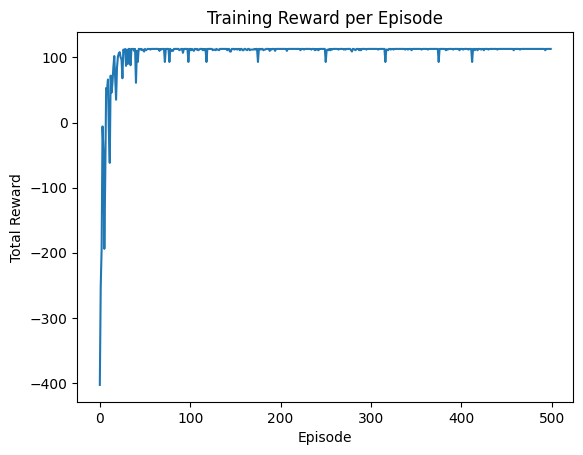

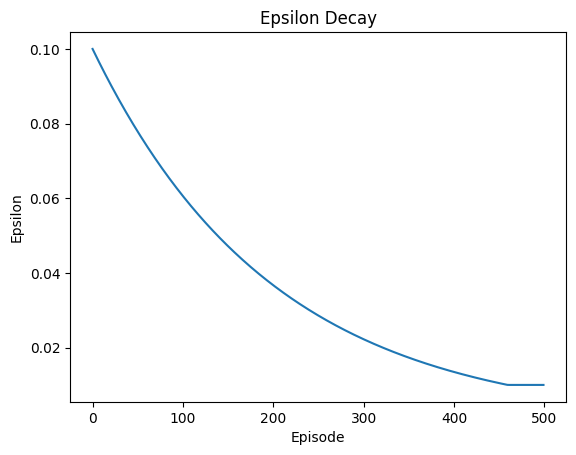

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


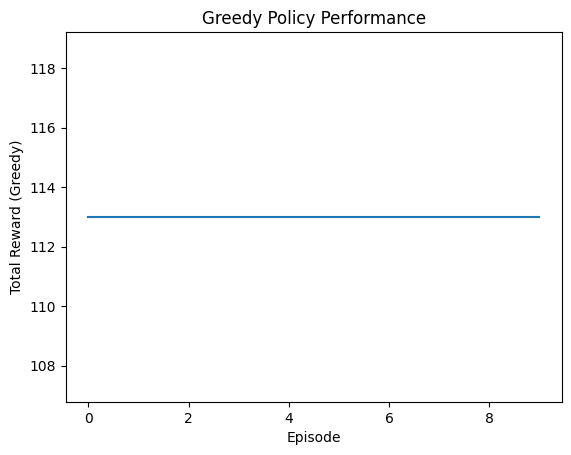


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . R . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [43]:
Q = defaultdict(lambda: np.zeros(n_actions))

rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table1.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Deterministic Env
- Model Iteration 1
> Hyperparameters 
> 
>Exploration
>
> epsilon = 0.1 (90% exploit)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 97.68

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ 462.62164826 2847.36819166  680.66412023  321.66329702 1270.54518257
  782.70592478]
(np.int8(1), np.int8(0), np.int8(0)): [ 739.93856068 2936.11608704  301.25775122  331.50115533 1047.69750161
  884.97566458]
(np.int8(0), np.int8(1), np.int8(0)): [  -1.71091457  -10.92848941 1094.61223735   -1.28775991   -1.62951965
   -1.75680386]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.03189033 -13.17830762  -1.03714269   0.83154205  -0.89298181
  -1.00171748]
(np.int8(0), np.int8(3), np.int8(0)): [ 0.03340678  7.59179087 -0.4868577  -0.4972591   0.10106234 -0.48647558]
(np.int8(1), np.int8(3), np.int8(0)): [-3.06026200e-01  8.57241430e+02  1.35577929e+01  6.95029821e-01
 -1.99900000e-01  8.39089317e-01]
(np.int8(2), np.int8(3), np.int8(0)): [ 200.98497936  170.76791854  962.08403651  377.68172649 3305.79305292
  602.62838159]
(np.int8(2), np.int8(4), np.int8(0)): [-3.89835344e-01

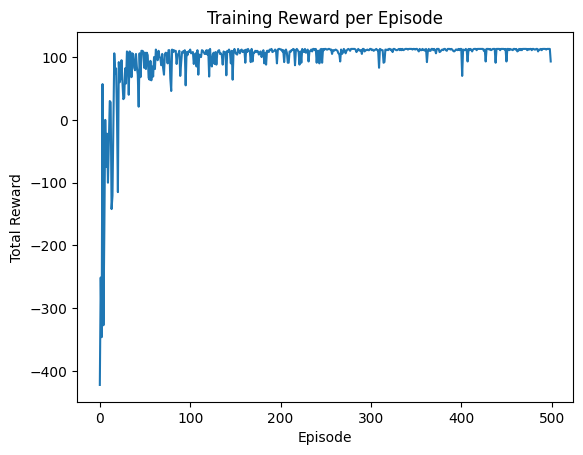

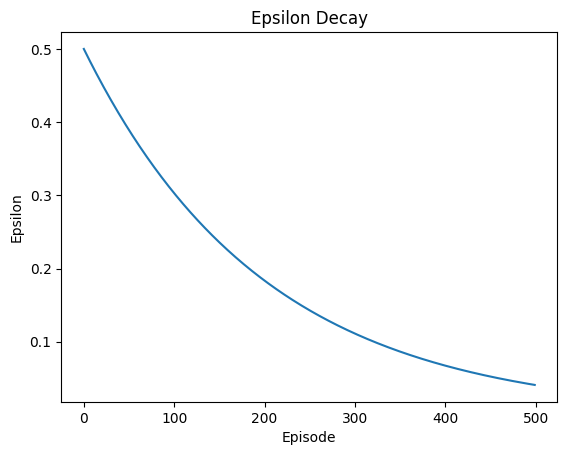

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


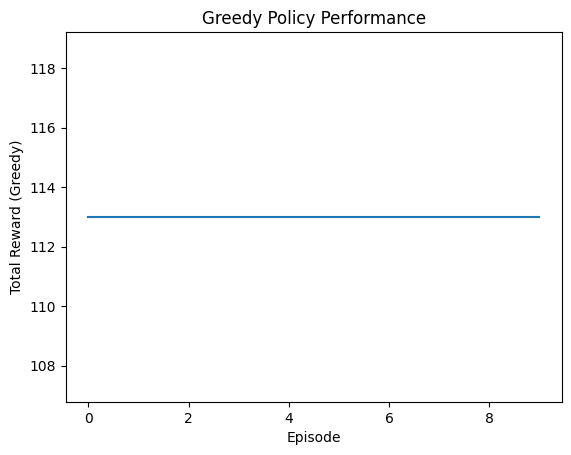


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . R . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [44]:
epsilon = 0.5     

Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Deterministic Env
-Iteration2
> Hyperparameters 
> 
>Exploration
>
> epsilon = 0.9 (10% exploit 90% explore)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 70.08

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [1250.57166738 2765.9927241  1068.98523377  615.96775727  631.43697018
 1117.58876049]
(np.int8(0), np.int8(1), np.int8(0)): [ 1.62951683e+01  1.01142720e+02  1.31589968e+03 -9.83583058e-01
  2.14533167e+01  1.75015376e+01]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.16949875 -14.80349161  -0.34984115   2.92139262  -1.25329443
  -0.90619095]
(np.int8(1), np.int8(0), np.int8(0)): [1551.80057532 2852.93816796  694.62428857 1257.98387264 1179.41534273
  923.45744842]
(np.int8(2), np.int8(0), np.int8(0)): [1445.18181434  505.204396   1343.84481734 2941.95906727  590.32460248
 1435.29063247]
(np.int8(0), np.int8(3), np.int8(0)): [ 1.83896248e+00  6.07801579e+01 -5.32110224e-01 -7.32063103e-01
 -3.33093073e-02 -9.00488838e-01]
(np.int8(0), np.int8(4), np.int8(0)): [-0.68489839  5.8289149  -0.7770811  -0.91155186 -0.8406579  -0.6420119 ]
(np.int8(0), np.int8(5), np.int8(0)): [-0.

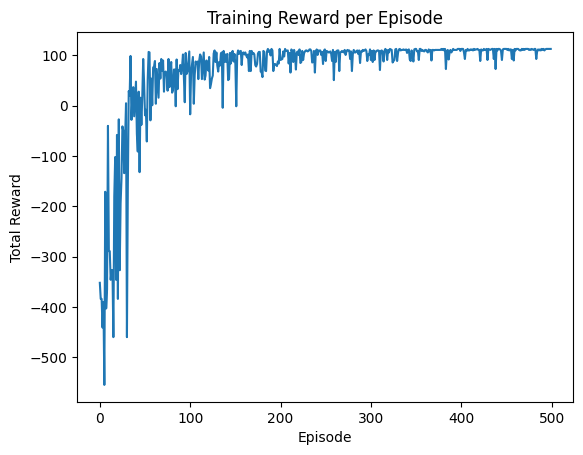

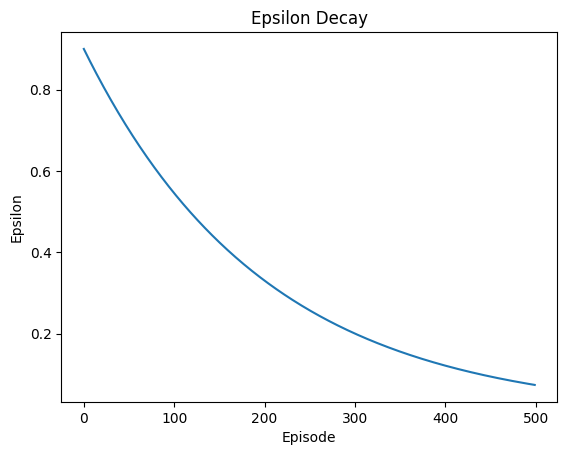

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


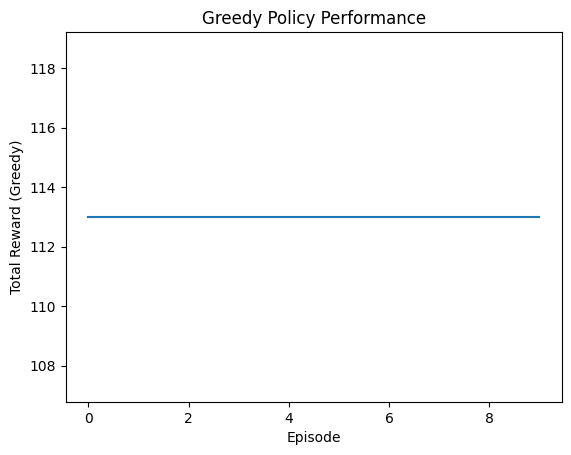


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . R .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [45]:
epsilon = 0.9     

Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Deterministic Env
-Iteration3
> Hyperparameters 
> 
>Exploration
>
> epsilon = 0.6 (60% explore)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 92.77

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ 832.65548631  274.75110907 1127.55517657 2841.99209806 1126.83988155
  781.70229337]
(np.int8(1), np.int8(0), np.int8(0)): [ 8.81132105e+02  5.96232057e-01  3.38466972e+01 -1.41450747e+01
  4.96174960e+01  3.02080364e+00]
(np.int8(2), np.int8(0), np.int8(0)): [-0.76359244 -0.93975916 -0.83352629  8.31064981 -0.73703361 -0.45346021]
(np.int8(3), np.int8(0), np.int8(0)): [-0.72144076 -0.80977347 -0.7419201  -0.69340201 -0.79270468 -0.78631718]
(np.int8(3), np.int8(1), np.int8(0)): [ 0.06300366 -0.47124838 -0.64482586  1.3087414  -0.38952019 -0.64026213]
(np.int8(4), np.int8(1), np.int8(0)): [-0.49761487 -0.5506496  -0.50602583 -0.4534462  -0.48727034 -0.49448744]
(np.int8(4), np.int8(0), np.int8(0)): [-0.78601176 -0.76372144 -0.49802286 -0.5680356  -0.58598998 -0.5787801 ]
(np.int8(2), np.int8(1), np.int8(0)): [-5.90852545e+00 -5.85602540e-01 -6.49508703e-01  1.04580587e+

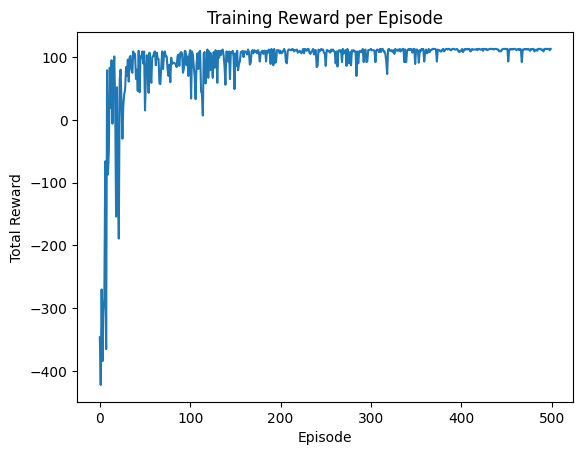

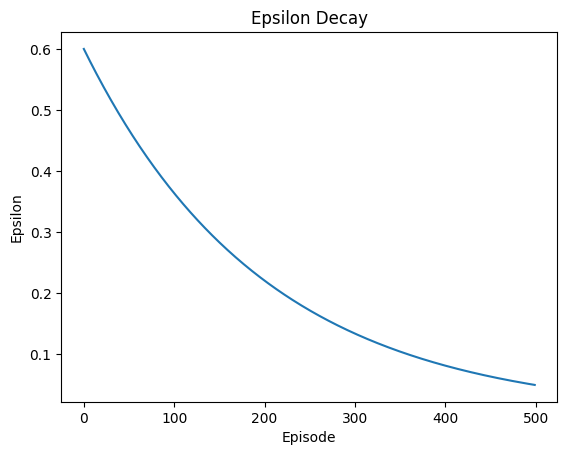

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


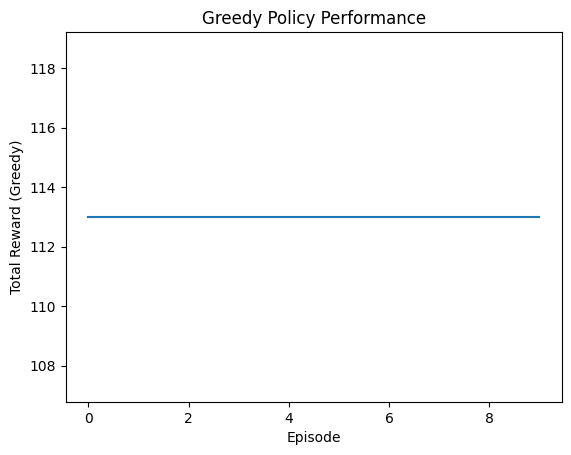


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [46]:
epsilon = 0.6     
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Deterministic Env
-Iteration1
> Hyperparameters 
> 
>Discount Factor
>
> epsilon = 0.5 (50% explore)
> 
> gamma = 0.80 (high learning , attains max rewards fast)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 97.33

Trained Q-table (first 10 states):
(np.int8(1), np.int8(0), np.int8(0)): [16.63198643 58.90375253 19.10582416 -3.11360225 31.5889477  22.9055854 ]
(np.int8(0), np.int8(0), np.int8(0)): [18.25703936 46.11849788 17.71818671  5.62434534 13.80403416 18.79861776]
(np.int8(0), np.int8(1), np.int8(0)): [-1.29535235 -7.08380849 21.64486458 -0.93832437 -1.30530626 -1.29898229]
(np.int8(2), np.int8(0), np.int8(0)): [24.36361986  7.1710878  39.98795    74.88573659 30.58475421 34.4532997 ]
(np.int8(3), np.int8(0), np.int8(0)): [32.36755191 -0.5186502   0.64038427 -0.44483043 -0.10313923 -0.48039602]
(np.int8(2), np.int8(1), np.int8(0)): [34.12166274 12.55591193 37.16218687 94.86258513 46.54442816 39.69596454]
(np.int8(3), np.int8(1), np.int8(0)): [ 4.17998408e+01 -3.59100000e-01  2.37966793e-01 -1.31510721e-02
 -1.06390557e-01  1.95901002e-01]
(np.int8(3), np.int8(2), np.int8(0)): [ 6.83792103e+01 -2.79000000e-01 -1.93479426e-01 -3.29916000e-01
 -1.639348

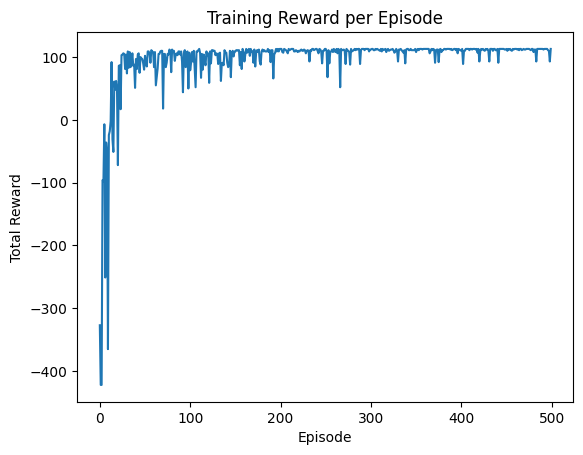

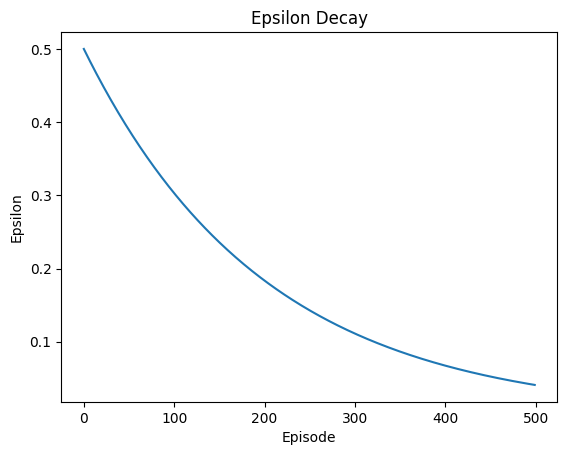

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


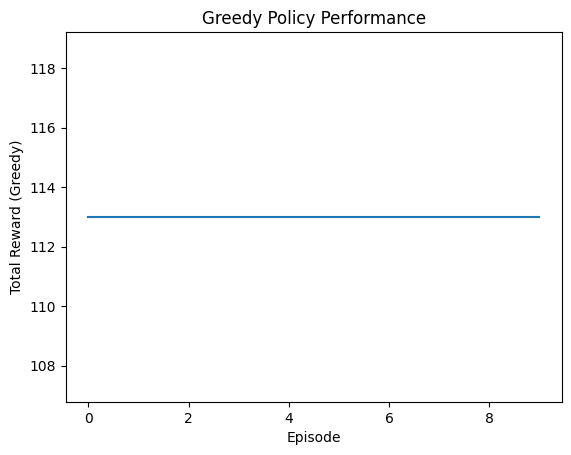


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [47]:
gamma = 0.8       
epsilon = 0.5     
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Deterministic Env
-Iteration2
> Hyperparameters 
> 
>Discount Factor
>
> epsilon = 0.5 (50% explore)
> 
> gamma = 0.50 (moderate learning , attains max rewards moderately)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 95.14

Trained Q-table (first 10 states):
(np.int8(0), np.int8(1), np.int8(0)): [ -1.21023084 -18.2043504   -1.5055657   -0.2421875   -1.23040118
  -1.2295655 ]
(np.int8(0), np.int8(0), np.int8(0)): [-1.60848063 -1.57807702 -1.60797169 -1.12109375 -1.61167338 -1.5797824 ]
(np.int8(1), np.int8(0), np.int8(0)): [ -1.46082054  -1.01648332  -1.39919491 -16.73311926  -1.33875115
  -1.34937542]
(np.int8(0), np.int8(2), np.int8(0)): [ -0.43562798 -16.58959416  -1.14727942   1.515625    -0.58668498
  -0.57151233]
(np.int8(0), np.int8(3), np.int8(0)): [ 1.06085215  5.03125    -0.41285837 -0.65921258  0.77522973  1.20079127]
(np.int8(1), np.int8(3), np.int8(0)): [  0.92329701  12.0625     -11.70003225   0.5830956    4.09127107
   4.30670311]
(np.int8(2), np.int8(0), np.int8(0)): [-0.96518588 -0.87009875 -0.90641699  0.4699398  -0.90486433 -0.94784448]
(np.int8(3), np.int8(0), np.int8(0)): [-0.63598368 -0.635409   -0.59579123 -0.62940527 -0.60312178 -0.59904925

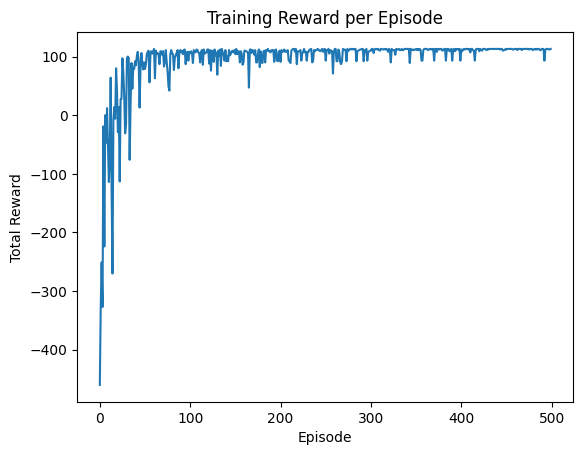

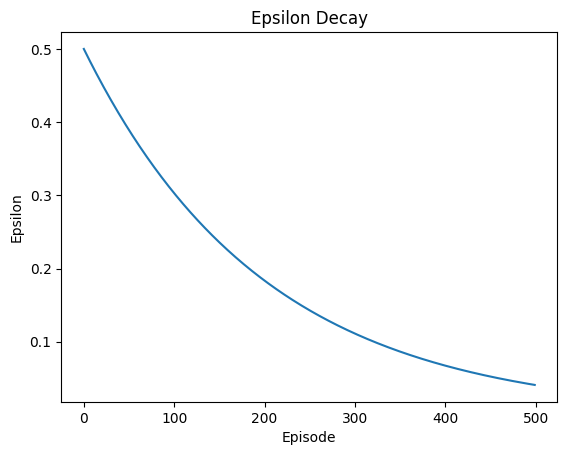

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


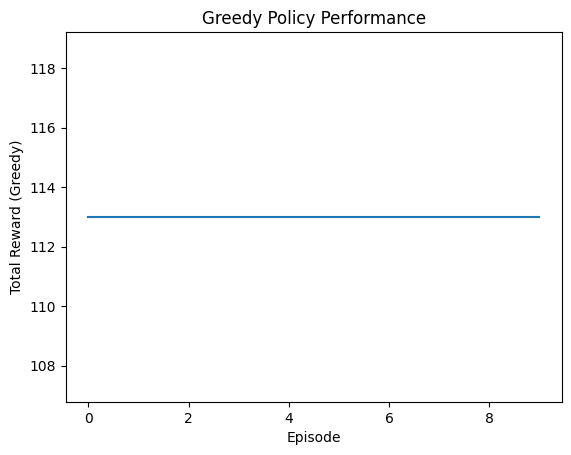


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . R .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [48]:
gamma = 0.5      
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Deterministic Env
-Iteration3
> Hyperparameters 
> 
>Discount Factor
>
> epsilon = 0.5 (50% explore)
> 
> gamma = 0.10 (low learning , attains max rewards slowly)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 72.51

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [-1.11095995 -1.11086111 -1.11091642 -1.11086111 -1.11101184 -1.1109855 ]
(np.int8(1), np.int8(0), np.int8(0)): [ -1.1103365   -1.1086111   -1.10975845 -18.80374634  -1.10955247
  -1.10980649]
(np.int8(0), np.int8(1), np.int8(0)): [ -1.1092773  -19.60432191  -1.10905958  -1.10861132  -1.10902705
  -1.10926138]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.09490678 -17.90081611  -1.09244934  -1.08611167  -1.09727008
  -1.09162973]
(np.int8(0), np.int8(3), np.int8(0)): [-1.00903638 -0.86111106 -0.92440662 -0.92383969 -0.96825827 -0.95592106]
(np.int8(0), np.int8(4), np.int8(0)): [-0.75203469 -0.77007171 -0.76423955 -0.80777158 -0.75047769 -0.74878291]
(np.int8(1), np.int8(4), np.int8(0)): [-0.59622369 -0.5870909  -0.60958139 -0.6325294  -0.63500472 -0.63272371]
(np.int8(0), np.int8(5), np.int8(0)): [-0.71526973 -0.74483827 -0.72022056 -0.71563792 -0.75199064 -0.71694455]
(np.i

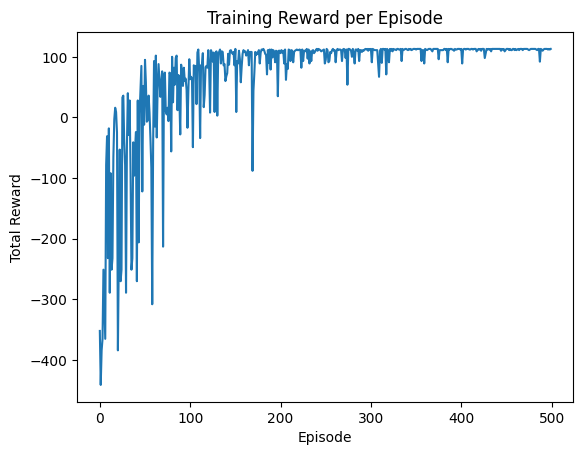

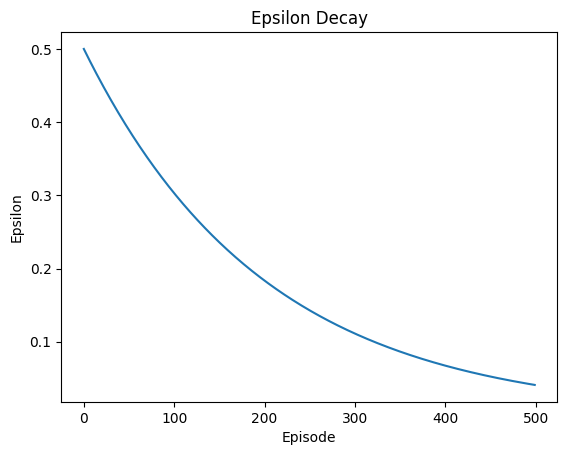

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


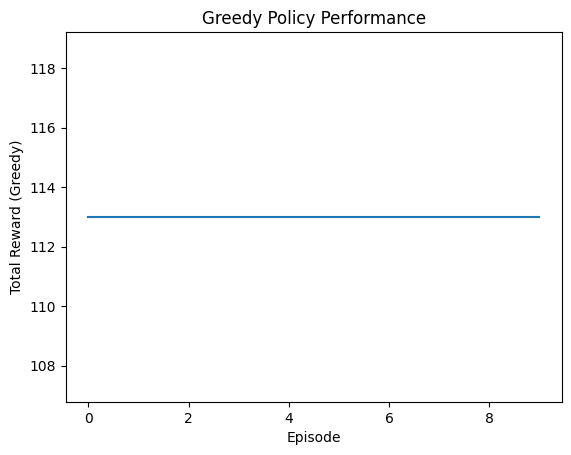


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [49]:
gamma = 0.1       
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")